In [49]:
import sys
print(sys.path)
import seaborn as sns
sns.set()

['', '/opt/conda/lib/python36.zip', '/opt/conda/lib/python3.6', '/opt/conda/lib/python3.6/lib-dynload', '/opt/conda/lib/python3.6/site-packages', '/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg', '/opt/conda/lib/python3.6/site-packages/IPython/extensions', '/home/yukimiki/.ipython', '/tmp/fastai/old']


In [50]:
sys.path.append("/tmp/fastai/old")

In [51]:
import fastai

In [52]:
from fastai.conv_learner import *

In [53]:
from fastai.dataset import *

In [54]:
from datetime import datetime
import pandas as pd
import numpy as np
np.random.seed(seed=32)
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
#from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip
from tensorboard_cb import TensorboardLogger
import torch
torch.manual_seed(7)
torch.cuda.manual_seed_all(7)
import utils_pytorch

In [55]:
nw = 20   #number of workers for data loader
arch = resnet34 #specify target architecture

In [56]:
train_names = list({f[:36] for f in os.listdir(utils_pytorch.TRAIN)})
test_names = list({f[:36] for f in os.listdir(utils_pytorch.TEST)})
# tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

data_info = pd.read_csv(utils_pytorch.LABELS)
tr_n, val_n = train_test_split(data_info, test_size = 0.1, 
                 stratify = data_info['Target'].map(lambda x: x[:3] if '27' not in x else '0'), random_state=42)
tr_n = tr_n['Id'].tolist()
val_n = val_n['Id'].tolist()

In [57]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(45, tfm_y=TfmType.NO),
                RandomFlip(),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    #stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    stats = A([0.0868 , 0.05959, 0.06522, 0.08891], [0.13044, 0.09792, 0.14862, 0.13281])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(utils_pytorch.pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],utils_pytorch.TRAIN), 
                (val_n,utils_pytorch.TRAIN), tfms, test=(test_names,utils_pytorch.TEST))
    md = ImageData(utils_pytorch.PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [58]:
bs = 16
sz = 256
md = get_data(sz,bs)

x,y = next(iter(md.trn_dl))
x.shape, y.shape

(torch.Size([16, 4, 256, 256]), torch.Size([16, 28]))

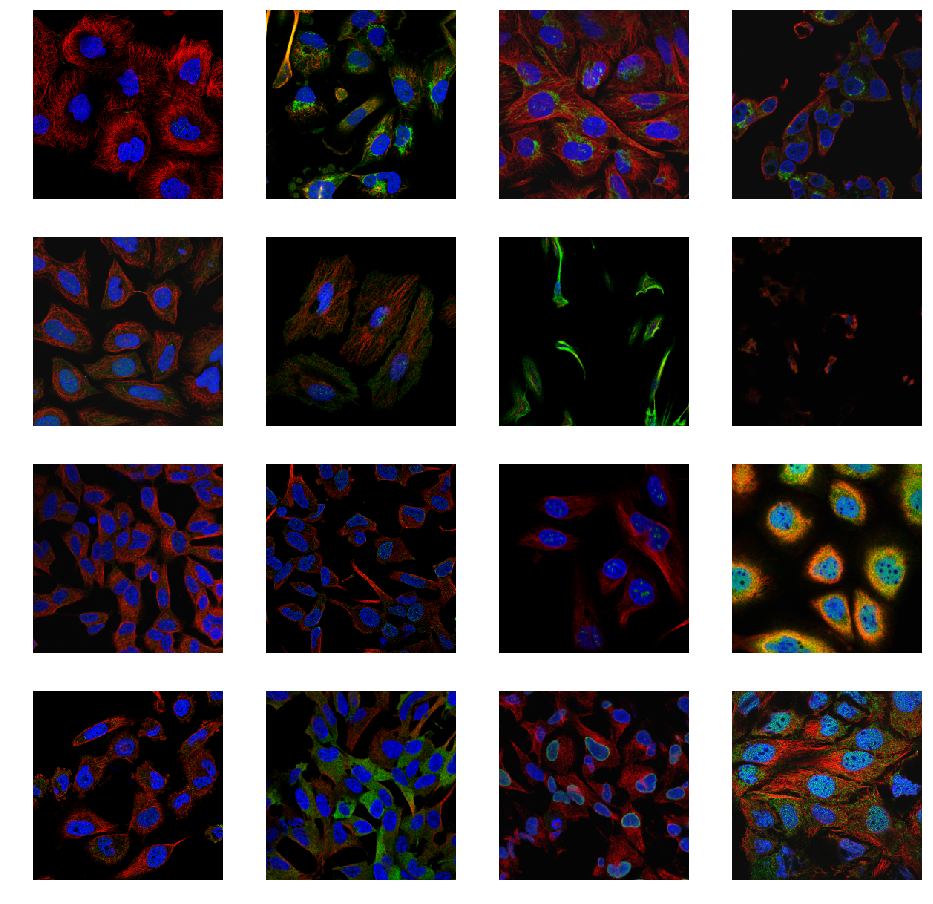

In [59]:
utils_pytorch.display_imgs(np.asarray(md.trn_ds.denorm(x)))

In [60]:
# channel_avr, channel_std = utils_pytorch.calculate_stats(md)
# print(channel_avr, channel_std)

In [62]:
sz = 256 #image size
bs = 64  #batch size

dir_name = datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
dir_name = dir_name + f'_size{sz}'
print(dir_name)
dir_path = os.path.join('test', dir_name)
best_model_path = dir_name + 'best_resnet'


md = get_data(sz,bs)
learner = utils_pytorch.ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = utils_pytorch.FocalLoss()
learner.metrics = [utils_pytorch.acc, utils_pytorch.f1_torch]
tb_logger = TensorboardLogger(learner.model, md, dir_path, metrics_names=['acc', 'f1'])
#save_best_model = SaveBestModel(model=learner.model)

20181129055744_size256


In [63]:
#learner.summary

 77%|███████▋  | 336/436 [02:44<00:44,  2.27it/s, loss=9.06]

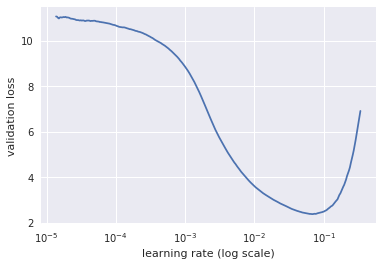

In [65]:
learner.lr_find()
learner.sched.plot()

In [66]:
lr = 1e-2
learner.fit(lr,1, best_save_name=best_model_path, callbacks=[tb_logger])

epoch      trn_loss   val_loss   acc        f1_torch   
    0      1.284039   1.217724   0.947221   0.030781  


[1.217723722009892, 0.9472214968508275, 0.030780777047499725]

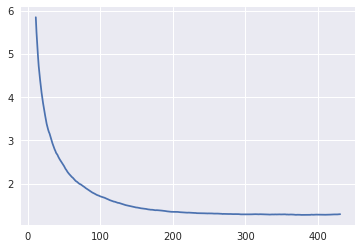

In [67]:
learner.sched.plot_loss()

In [68]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [69]:
learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20), best_save_name=best_model_path, callbacks=[tb_logger])

epoch      trn_loss   val_loss   acc        f1_torch   
    0      0.955067   0.9241     0.957977   0.236133  
    1      0.833034   0.769511   0.964987   0.380813  
    2      0.85145    0.788334   0.963918   0.365498  
    3      0.765353   0.710467   0.967342   0.435081  
    4      0.780153   0.734603   0.965481   0.405963  
    5      0.72298    0.667944   0.969055   0.480555  
    6      0.750947   0.735197   0.965561   0.464125  
    7      0.68065    0.65006    0.969572   0.501534  


[0.6500602613851677, 0.9695716557048616, 0.5015336070665215]

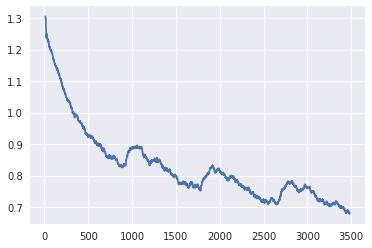

In [70]:
learner.sched.plot_loss()

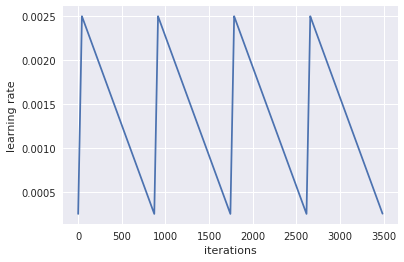

In [71]:
learner.sched.plot_lr()

In [73]:
learner.fit(lrs/4,2,cycle_len=4,use_clr=(10,20), best_save_name=best_model_path, callbacks=[tb_logger])

epoch      trn_loss   val_loss   acc        f1_torch   
    0      0.739966   0.729212   0.966182   0.455234  
    1      0.699039   0.684264   0.967905   0.45828   
    2      0.670682   0.636158   0.96979    0.53254   
    3      0.618886   0.60299    0.971399   0.541288  
    4      0.704476   0.684615   0.967549   0.46967   
    5      0.66048    0.660417   0.968262   0.48669   
    6      0.625571   0.61789    0.970951   0.561984  
    7      0.583676   0.582436   0.972536   0.565626  


[0.582436050419028, 0.9725363521502285, 0.5656262709060385]

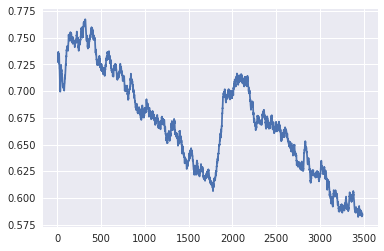

In [74]:
learner.sched.plot_loss()

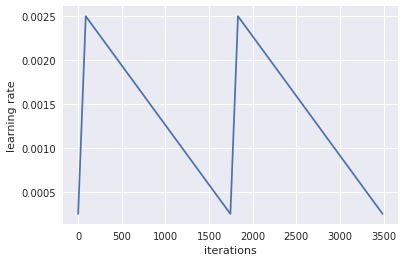

In [75]:
learner.sched.plot_lr()

In [76]:
learner.fit(lrs/16,1,cycle_len=8,use_clr=(5,20), best_save_name=best_model_path, callbacks=[tb_logger])

epoch      trn_loss   val_loss   acc        f1_torch   
    0      0.576972   0.596607   0.972123   0.561762  
    1      0.562643   0.586866   0.972433   0.580909  
    2      0.559154   0.578697   0.972697   0.563803  
    3      0.547477   0.579588   0.972674   0.579183  
    4      0.537161   0.570945   0.973214   0.593381  
    5      0.517328   0.570744   0.973145   0.598039  
    6      0.506251   0.564361   0.973594   0.6146    
    7      0.502725   0.564521   0.973651   0.618946  


[0.5645212929988306, 0.9736509896920301, 0.6189464213304998]

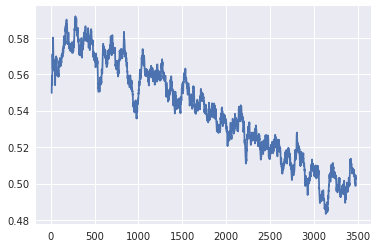

In [77]:
learner.sched.plot_loss()

In [78]:
learner.save('ResNet34_256_1')

In [79]:
learner.load(best_model_path)

In [80]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

In [81]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(utils_pytorch.name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [82]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

Thresholds:  [0.51333 0.52556 0.5378  0.49162 0.51677 0.52561 0.51214 0.60254 0.4462  0.57656 0.5331  0.53148 0.55802
 0.44733 0.49545 0.54946 0.42772 0.38134 0.44997 0.49314 0.46647 0.49118 0.47991 0.57694 0.50146 0.49013
 0.56738 0.33029]
F1 macro:  0.7175127280355618
F1 macro (th = 0.5):  0.6591110581607829
F1 micro:  0.7655398037077428


In [83]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > th).mean(axis=0))

Fractions:  [0.47812 0.03539 0.10457 0.05148 0.04794 0.0621  0.02059 0.07625 0.00097 0.00129 0.00097 0.0325  0.01512
 0.01287 0.03282 0.00032 0.01094 0.00676 0.02864 0.04601 0.00386 0.12323 0.02124 0.08333 0.01094 0.29987
 0.00772 0.00032]
Fractions (true):  [0.42535 0.03861 0.11776 0.04923 0.05856 0.07497 0.03185 0.08784 0.00129 0.00161 0.00097 0.03539 0.0222
 0.01544 0.03636 0.00064 0.01673 0.00804 0.03024 0.04698 0.00547 0.12323 0.02574 0.09299 0.0103  0.26062
 0.01062 0.00032]


In [84]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [85]:
def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(utils_pytorch.SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [86]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

Fractions:  [0.41437 0.04341 0.08358 0.06375 0.06982 0.10708 0.047   0.09742 0.00077 0.00077 0.00051 0.03871 0.03957
 0.01461 0.03572 0.00009 0.02632 0.01709 0.02752 0.06392 0.00521 0.14613 0.03222 0.09776 0.01145 0.27833
 0.0335  0.02273]


In [87]:
print('Thresholds: ',th_t)
print('F1 macro: ',f1_score(y, pred>th_t, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th_t, average='micro'))

Thresholds:  [0.565 0.39  0.55  0.345 0.33  0.39  0.33  0.45  0.38  0.39  0.34  0.42  0.31  0.38  0.49  0.5   0.38  0.43
 0.46  0.4   0.39  0.505 0.37  0.47  0.41  0.545 0.32  0.1  ]
F1 macro:  0.615540728021973
F1 macro (th = 0.5):  0.6591110581607829
F1 micro:  0.7152330079204274


In [88]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [89]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(utils_pytorch.name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [90]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

Thresholds:  [0.61499 0.38953 0.57992 0.3627  0.32471 0.45717 0.34599 0.52471 0.16779 0.15603 0.12558 0.39201 0.30169
 0.39263 0.40473 0.17046 0.37715 0.46485 0.46117 0.41816 0.33931 0.53521 0.39197 0.54421 0.46438 0.58662
 0.3464  0.15296]
Fractions:  [0.36344 0.0435  0.07477 0.05777 0.07289 0.07392 0.04127 0.07469 0.00735 0.00829 0.00632 0.04324 0.04162
 0.01384 0.04384 0.00743 0.027   0.01393 0.02717 0.05794 0.00957 0.12468 0.02735 0.0746  0.01    0.21954
 0.02777 0.00615]
Fractions (th = 0.5):  [0.47342 0.03239 0.09879 0.02974 0.03187 0.05845 0.01709 0.08135 0.00026 0.00034 0.00017 0.02871 0.01555
 0.00872 0.03487 0.00009 0.01179 0.01111 0.01957 0.03726 0.00239 0.14997 0.01607 0.08742 0.00906 0.34302
 0.0094  0.00009]


In [91]:
print('Thresholds: ',th_t)
print('F1 macro: ',f1_score(y, pred>th_t, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th_t, average='micro'))

Thresholds:  [0.61499 0.38953 0.57992 0.3627  0.32471 0.45717 0.34599 0.52471 0.16779 0.15603 0.12558 0.39201 0.30169
 0.39263 0.40473 0.17046 0.37715 0.46485 0.46117 0.41816 0.33931 0.53521 0.39197 0.54421 0.46438 0.58662
 0.3464  0.15296]
F1 macro:  0.5505585510064565
F1 macro (th = 0.5):  0.6591110581607829
F1 micro:  0.71015625


In [92]:
save_pred(pred_t,th_t,'protein_classification_f.csv')

In [93]:
save_pred(pred_t,th,'protein_classification_v.csv')
save_pred(pred_t,0.5,'protein_classification_05.csv')

In [94]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'protein_classification_c.csv')

In [95]:
labels = pd.read_csv(utils_pytorch.LABELS).set_index('Id')
label_count = np.zeros(len(utils_pytorch.name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(utils_pytorch.name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([12885.,  1254.,  3621.,  1561.,  1858.,  2513.,  1008.,  2822.,    53.,    45.,    28.,  1093.,
          688.,   537.,  1066.,    21.,   530.,   210.,   902.,  1482.,   172.,  3777.,   802.,  2965.,
          322.,  8228.,   328.,    11.]),
 array([0.41468, 0.04036, 0.11654, 0.05024, 0.0598 , 0.08088, 0.03244, 0.09082, 0.00171, 0.00145, 0.0009 ,
        0.03518, 0.02214, 0.01728, 0.03431, 0.00068, 0.01706, 0.00676, 0.02903, 0.0477 , 0.00554, 0.12156,
        0.02581, 0.09542, 0.01036, 0.2648 , 0.01056, 0.00035]))

In [96]:
th_t = fit_test(pred_t,label_fraction)
th_t[th_t<0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t.csv')

Thresholds:  [0.56229 0.41457 0.45498 0.39178 0.36009 0.44405 0.38651 0.47413 0.29811 0.34256 0.30368 0.44695 0.41411
 0.35821 0.51032 0.3432  0.44843 0.57799 0.46027 0.458   0.39495 0.54195 0.40891 0.47978 0.45216 0.55524
 0.48739 0.31599]
Fractions:  [0.41668 0.03957 0.11511 0.04811 0.05683 0.07853 0.03119 0.08981 0.00162 0.00145 0.00085 0.03461 0.02188
 0.01649 0.0341  0.00068 0.01683 0.00641 0.02743 0.04666 0.00479 0.11998 0.0247  0.09409 0.01034 0.2644
 0.01034 0.00026]


In [97]:
print('Thresholds: ',th_t)
print('F1 macro: ',f1_score(y, pred>th_t, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th_t, average='micro'))

Thresholds:  [0.56229 0.41457 0.45498 0.39178 0.36009 0.44405 0.38651 0.47413 0.29811 0.34256 0.30368 0.44695 0.41411
 0.35821 0.51032 0.3432  0.44843 0.57799 0.46027 0.458   0.39495 0.54195 0.40891 0.47978 0.45216 0.55524
 0.48739 0.31599]
F1 macro:  0.6621097792874325
F1 macro (th = 0.5):  0.6591110581607829
F1 micro:  0.7392996108949417
